In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from src import Helpers
import pickle

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# Load the dataframe for characters (with predicted MainCharType)
full_characters = pd.read_pickle('full_characters_final')

We know the name of the actor/actress for each character in this dataframe.

In [3]:
len(full_characters[full_characters.Actor_name.isna()])

0

Let's drop the characters for which MainCharType is unknown. This leaves us with about 21k characters. 

Recall that seven categories exist for MainCharType : "Adventurers and Heroes", "Emotionnal and Romantic Tropes", etc

In [4]:
full_characters.dropna(subset=['MainCharType'], inplace=True)
len(full_characters)

21170

Let's split the dataset between actors and actresses :

In [5]:
male_characters = full_characters[full_characters["Actor gender"] == 'M']
female_characters = full_characters[full_characters["Actor gender"] == 'F']

In [7]:
# We group characters by actor
male_actor_roles = male_characters.groupby('Actor_name')['MainCharType'].apply(list)
female_actor_roles = female_characters.groupby('Actor_name')['MainCharType'].apply(list)
# And keep actors that have at least 2 roles at their credit
male_mask = male_actor_roles.apply(lambda x : len(x)) >= 2
female_mask = female_actor_roles.apply(lambda x : len(x)) >= 2
male_actor_roles = male_actor_roles.loc[male_mask]
female_actor_roles = female_actor_roles.loc[female_mask]
male_actor_roles

Actor_name
50 Cent              [Emotional and Romantic Tropes, Emotional and ...
A. J. Bowen          [Adventurers and Heroes, Emotional and Romanti...
Aaron Eckhart        [Emotional and Romantic Tropes, Moral Ambiguit...
Aaron Johnson        [Moral Ambiguity and Antagonists, Moral Ambigu...
Aaron Stanford       [Everyday Characters and Tropes, Everyday Char...
                                           ...                        
Zach Galifianakis    [Everyday Characters and Tropes, Emotional and...
Zachary Gordon       [Stereotypes and Tropes, Stereotypes and Trope...
Zachary Levi         [Everyday Characters and Tropes, Complex Perso...
Zachary Quinto       [Moral Ambiguity and Antagonists, Occupation a...
Zachary Scott        [Stereotypes and Tropes, Everyday Characters a...
Name: MainCharType, Length: 1814, dtype: object

In [8]:
female_actor_roles

Actor_name
A. J. Cook             [Emotional and Romantic Tropes, Moral Ambiguit...
Aaliyah                [Adventurers and Heroes, Moral Ambiguity and A...
Abbie Cornish          [Occupation and Professions, Emotional and Rom...
Abigail Breslin        [Emotional and Romantic Tropes, Stereotypes an...
Adrienne Barbeau       [Stereotypes and Tropes, Everyday Characters a...
                                             ...                        
Yvonne Strzechowski    [Emotional and Romantic Tropes, Stereotypes an...
Yvonne Zima             [Stereotypes and Tropes, Adventurers and Heroes]
Zhang Ziyi             [Complex Personalities, Complex Personalities,...
Zoe Saldana            [Emotional and Romantic Tropes, Stereotypes an...
Zooey Deschanel        [Occupation and Professions, Emotional and Rom...
Name: MainCharType, Length: 1084, dtype: object

This leaves us with 1814 actors and 1084 actresses. Now, we vectorize the list of MainCharType by actor, to prepare clustering or PCA.

Each vector will have the following form :

['Complex Personalities', 'Adventurers and Heroes', 'Stereotypes and Tropes', 'Occupation and Professions', 'Moral Ambiguity and Antagonists', 'Everyday Characters and Tropes', 'Emotional and Romantic Tropes']

With a +1 for each time an actor has played a character falling into one of these 7 categories.

Then we normalize vectors (account for varying carrer duration between actors). Or maybe not ?

In [9]:
tropes = ['Complex Personalities', 'Adventurers and Heroes', 'Stereotypes and Tropes',
          'Occupation and Professions', 'Moral Ambiguity and Antagonists', 
          'Everyday Characters and Tropes', 'Emotional and Romantic Tropes']

In [10]:
def vectorize_roles_normalized(list_of_roles):
    "Takes a list of roles of any length, returns a normalized vector"
    
    dico = {'Complex Personalities':0, 'Adventurers and Heroes':0, 'Stereotypes and Tropes':0,
            'Occupation and Professions':0, 'Moral Ambiguity and Antagonists':0,
            'Everyday Characters and Tropes':0, 'Emotional and Romantic Tropes':0}
    
    for trope in list_of_roles:
        dico[trope] +=1
        
    vector = [value for key,value in dico.items()]
    
    # Normalize 
    tot = sum(vector)
    norm_vector = [v/tot for v in vector]
    
    return(norm_vector)

In [11]:
male_actor_encoded = male_actor_roles.apply(lambda x : vectorize_roles_normalized(x))
female_actor_encoded = female_actor_roles.apply(lambda x : vectorize_roles_normalized(x))
male_actor_encoded

Actor_name
50 Cent              [0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, ...
A. J. Bowen                        [0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.5]
Aaron Eckhart        [0.0, 0.08333333333333333, 0.08333333333333333...
Aaron Johnson        [0.0, 0.0, 0.0, 0.0, 0.6666666666666666, 0.166...
Aaron Stanford                     [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
                                           ...                        
Zach Galifianakis    [0.0, 0.0, 0.0, 0.09090909090909091, 0.0909090...
Zachary Gordon       [0.0, 0.2857142857142857, 0.7142857142857143, ...
Zachary Levi                       [0.5, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0]
Zachary Quinto                     [0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0]
Zachary Scott                      [0.0, 0.0, 0.5, 0.0, 0.0, 0.5, 0.0]
Name: MainCharType, Length: 1814, dtype: object

## PCA

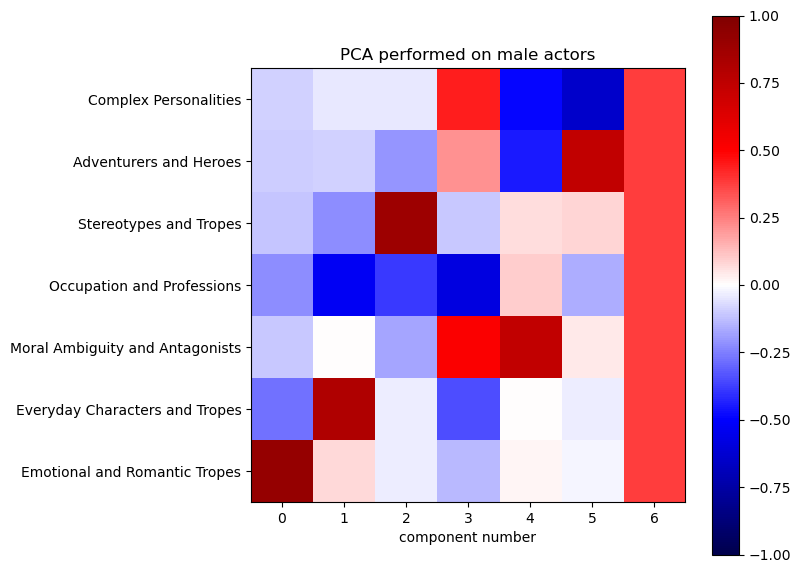

In [13]:
# Perform PCA on male actors dataset

# Note : data should always be centered before performing PCA on it. But sklearn takes care of this itself
pca = PCA(whiten=False)
# Perform PCA
data = male_actor_encoded.values.tolist()
pca.fit(data)

plt.figure(figsize=(7, 7))
plt.imshow(pca.components_.transpose(), cmap="seismic")
plt.clim([-1.0, 1.0])
plt.yticks(np.arange(len(tropes)), tropes)
plt.xlabel("component number")
plt.title("PCA performed on male actors")
plt.colorbar()
plt.savefig('PCA_male_actors.png', dpi=300, bbox_inches='tight')

In [14]:
male_added_variance = np.zeros_like(pca.explained_variance_ratio_)
for i in range(len(pca.explained_variance_ratio_)):
    male_added_variance[i:] += pca.explained_variance_ratio_[i]

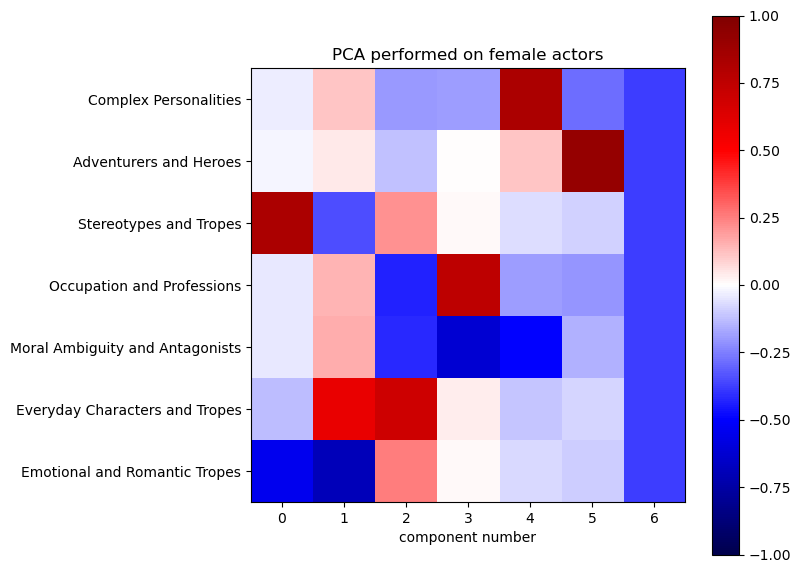

In [15]:
# Perform PCA on female actors dataset

pca = PCA(whiten=False)
# Perform PCA
data = female_actor_encoded.values.tolist()
pca.fit(data)

plt.figure(figsize=(7, 7))
plt.imshow(pca.components_.transpose(), cmap="seismic")
plt.clim([-1.0, 1.0])
plt.yticks(np.arange(len(tropes)), tropes)
plt.xlabel("component number")
plt.title("PCA performed on female actors")
plt.colorbar()
plt.savefig('PCA_female_actors.png', dpi=300, bbox_inches='tight')

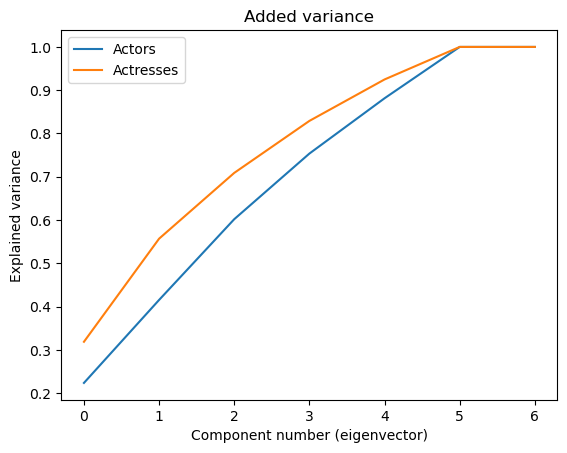

In [16]:
# Compare plots of explained variance between male and female actors
female_added_variance = np.zeros_like(pca.explained_variance_ratio_)
for i in range(len(pca.explained_variance_ratio_)):
    female_added_variance[i:] += pca.explained_variance_ratio_[i]

#Plot the added variance, respectively for male and female actors
plt.plot(male_added_variance, label="Actors")
plt.plot(female_added_variance, label="Actresses")
plt.legend()
plt.title("Added variance")
plt.xlabel("Component number (eigenvector)")
plt.ylabel("Explained variance")
plt.legend()
plt.savefig('PCA_added_variance.png', dpi=300, bbox_inches='tight')

# Add analysis

Have we just proved that actresses are asked to mainly play stupid roles ?